In [1]:
%load_ext autoreload
%autoreload 3

import sys
sys.path.insert(0, "/project/remote/golmi-dynamatt")
sys.path

['/project/remote/golmi-dynamatt',
 '/project/remote/golmi-dynamatt/app/compreg',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages']

In [36]:
import json
import os

import matplotlib.pyplot as plt

from model.pentomino import PieceConfig, RelPositions, Shapes, Colors, Board

data_dir = "/data/compreg/sets/pieces"

def sample_piece(color, shape):
    target = PieceConfig(color, shape, RelPositions.CENTER)
    board = Board(15, 15)  # we need at least size of 3 * 5
    board.add_piece_from_config(target)
    arr = board.to_rgb_array()
    center = arr[5:10, 5:10]
    return center

def to_image_name(color, shape):
    return f"{shape.value_name}_{color.value_name}.png"

def sample_image(color, shape):
    filename = to_image_name(color, shape)
    plt.axis("off")
    plt.imshow(sample_piece(color, shape))
    plt.savefig(data_dir + f"/{filename}", bbox_inches='tight')
    return filename

In [33]:
shapes = list(Shapes)
colors = list(Colors)
num_colors = len(colors)
num_shapes = len(shapes)
num_target_looks = num_shapes * num_colors
print(f"Shapes: {num_shapes} Colors: {num_colors} Combinations: {num_target_looks}")

Shapes: 12 Colors: 8 Combinations: 96


In [34]:
# NOTE: Actually more sensible to store all possible combinations of pieces only once!
# And then load them dynamically
num_distractors = 2
num_pieces = num_distractors + 1
print(f"Possible sets: {(num_target_looks)**(num_pieces)}")

Possible sets: 884736


In [35]:
# Compositional set on "Colors"
# All other distractors do NOT share the color, but at least one distractor shares the shape
num_other_looks = num_shapes*(num_colors-1) # unshare the color, but allow all shapes
num_share_looks = num_colors-1              # unshare the color, but shares the same shape as the target piece
print(f"Possible comp. sets: {num_targets * num_share_looks * num_other_looks**(num_distractors-1)}")

# Val/Test set on "Colors" (spare 1 combination of shape + color)
print(f"Possible val/test comp. sets: {12 * num_share_looks * num_other_looks**(num_distractors-1)}")

# Single piece set on "Colors" (1 combination of shape + color)
print(f"Possible single comp. sets: {1 * num_share_looks * num_other_looks**(num_distractors-1)}")

Possible comp. sets: 56448
Possible val/test comp. sets: 7056
Possible single comp. sets: 588


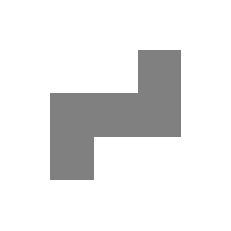

In [37]:
# We create all piece images first
# There are only 96 possible combinations (for now)
for shape_idx, shape in enumerate(shapes):
    for color_idx, color in enumerate(colors):
        sample_image(color, shape)

In [ ]:
"""
The annotation structure: 
Note: We produce one sample for each order (although the model should get invariant towards this anyway),
      but it seems easier to generate the dataset in this way (using for-loops) (for now)
[
  {
    "id": 0,
    "task": 0, # 0: use target color, 1: use target shape to discriminate
    "target": {
        "color": 2,
        "shape": 5,
        "image": "F_blue.png"
    },
    "distractors": [{
        "color": 1,
        "shape": 5,
        "image": "F_red.png"
    },{
        "color": 2,
        "shape": 9,
        "image": "V_blue.png"
    }]
  }
]
"""
counter = 0
samples = {
    "train": [],
    "val": [],
    "test": []
}
# Test first on "single piece" combs. (should be 588 ones)
for shape_idx, shape in enumerate(shapes):
    for color_idx, color in enumerate(colors):
        if color_idx == (shape_idx % len(colors)):
            split = "test"
        elif color_idx == (shape_idx + 1 % len(colors)):
            split = "val"
        else:
            split = "train"
        filename = to_image_name(color, shape)
        samples[split].append({
            "id": counter,
            "color": color.value,
            "shape": shape.value,
            "image": filename
        })
        counter += 1

for split in samples:
    with open(f"data/single/{split}.json", "w") as f:
        json.dump(samples[split], f)